# 探索的データ解析
## ライブラリのインポート

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import sys
# 自作ライブラリのインポートを行うために、パスを通す
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
# 前処理関数
from utils.preprocess import image_scaler

# 可視化
from utils.visualize import show_image

# データの可視化
from utils.load_datasets import load_all_datasets


## データの可視化

In [2]:
# データの読み込み
X_train, y_train, X_test = load_all_datasets()

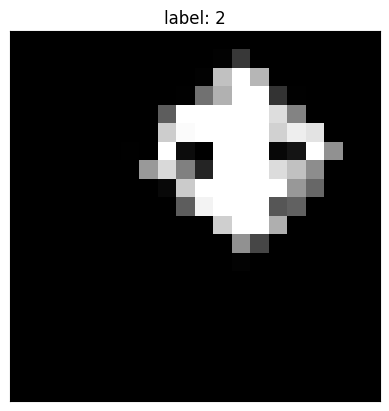

In [3]:
# 訓練データ
show_image(X_train[1], y_train[1])

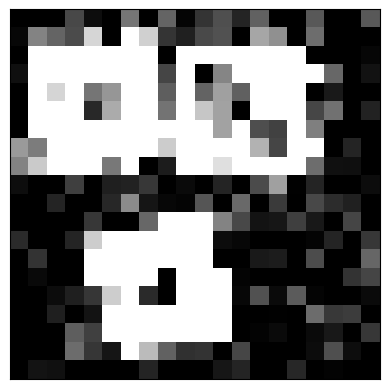

In [4]:
# テストデータ
show_image(X_test[10])

* 訓練データはノイズがない
* テストデータはノイズがあり、荒いデータとなっている

## データセットの作成
YOLOで転移学習を行うにあたって、データセットを作成する必要がある。今回はopencvを用いて作成してみる

In [5]:
# ライブラリのインポート
import cv2

# サイコロを作成する関数
from utils.make_datasets import make_dice

### 描画してみる

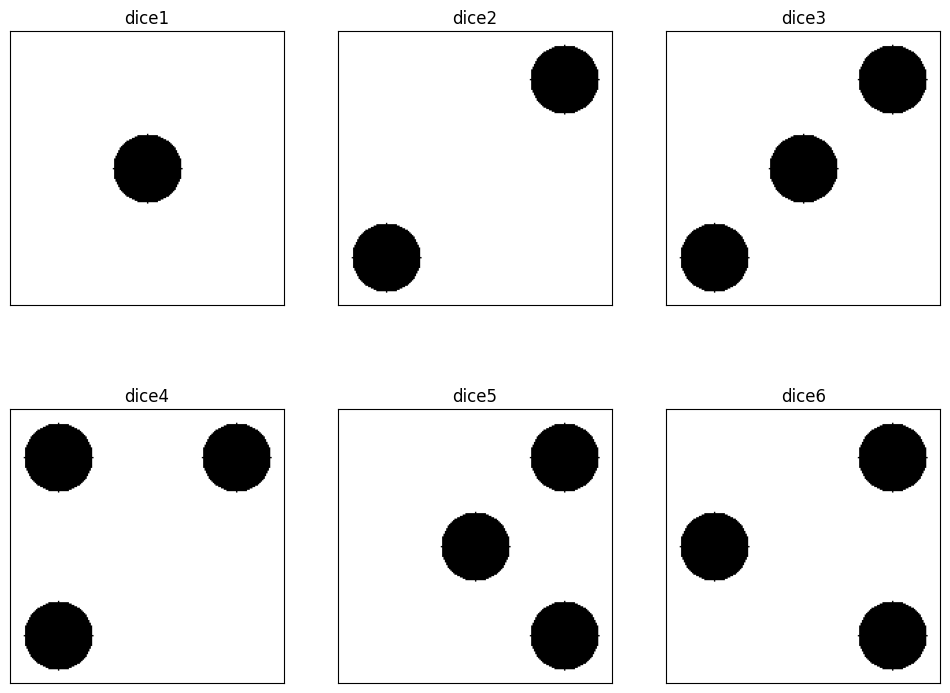

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(12, 9))
dices = [] # ダイスの配列を格納する

for i, ax in enumerate(axes.ravel()):
    num = i + 1 # サイコロの目
    dice = make_dice(num)
    dices.append(dice)
    ax.imshow(dice, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"dice{num}")

無事にサイコロが作成できたので、これを活用してYOLOで学習を行うためのデータセットを作成してみる \
datasets/dicesの中にサイコロの画像を保存しておく。

### データセットを作成する関数の動作確認

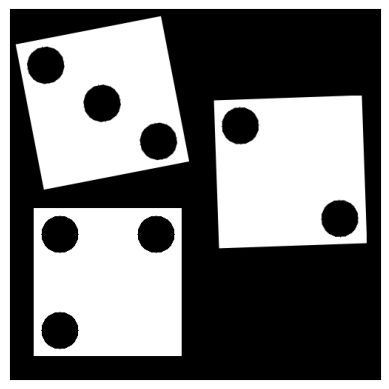

In [37]:
from utils.make_datasets import make_dataset

data = make_dataset((500, 500))
show_image(data)

500x500の画像であるが、作成することができた。resize処理などを行い、20x20へ変更する